In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import plotting as mp
import numpy as np
from operator import itemgetter

from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
%matplotlib inline
pd.set_option('display.max_columns',500)

In [6]:
project_name = 'project_5526'
filelocation='../capstone_data/Azimuth/clean/{}_featurized.csv'.format(project_name)
df = pd.read_csv(filelocation)
df['t'] = pd.to_datetime(df['t'], format='%Y-%m-%d %H:%M:%S')
df.set_index('t',inplace=True)

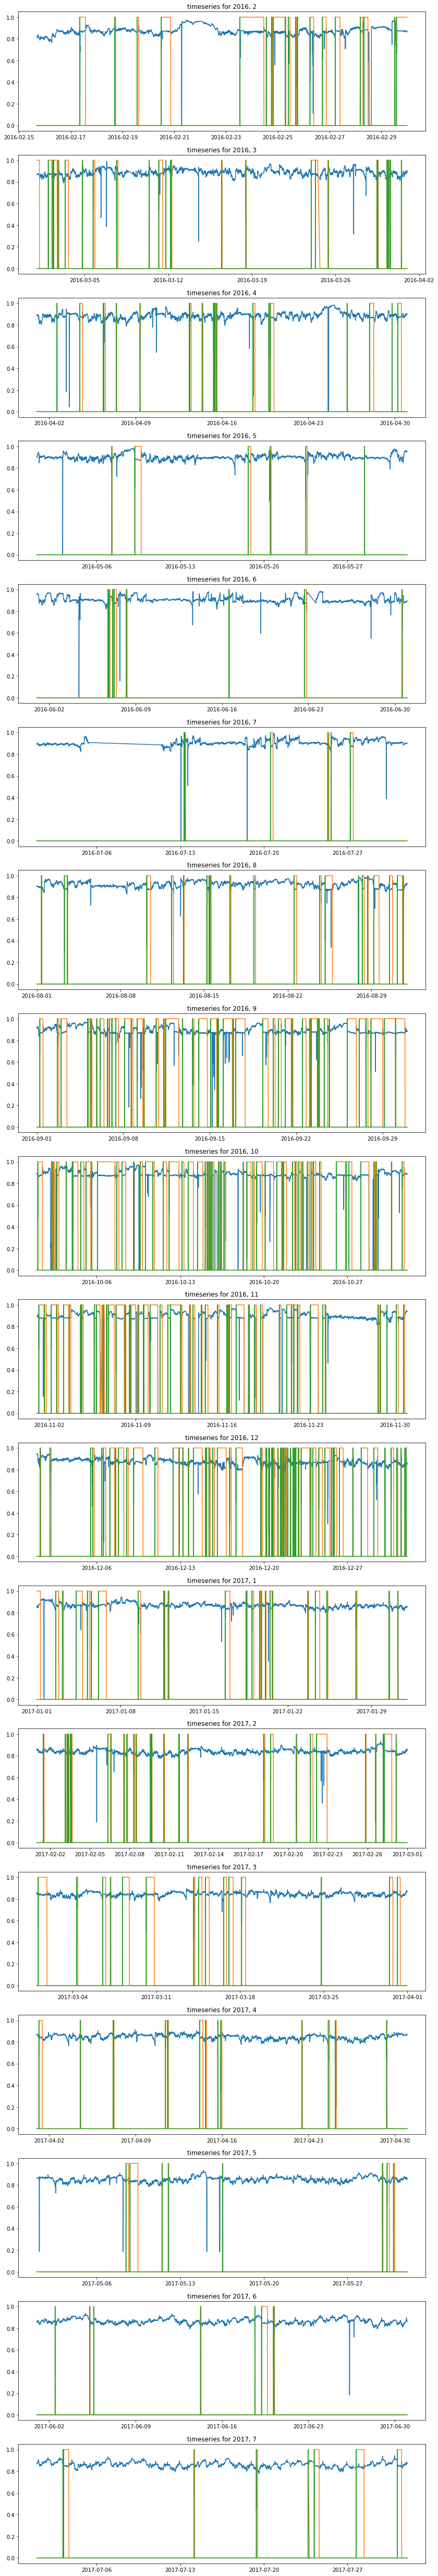

In [7]:
mp.plot_all_data(df, ['load_v1rms-1','relay_est','begin_gen'])

In [8]:
df.groupby(['begin_gen','relay_est'])['relay'].count()

begin_gen  relay_est
0          0            127009
           1             22785
1          1               438
Name: relay, dtype: int64

In [25]:
df.groupby(['relay_est'])['relay'].count()

relay_est
0    127009
1     23223
Name: relay, dtype: int64

## Baseline Model

Ideas:
-probability of outage at that point in time is based on the number of times an outage occurs in that hour from data collected.

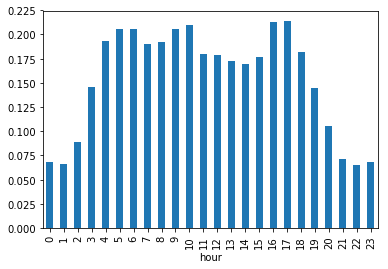

In [10]:
df['hour'] = df.index.hour
baseline_prob = df.groupby('hour')['relay_est'].mean()
baseline_prob.plot(kind='bar')

In [11]:
recall_scores=[]
precision_scores = []
f1_scores = []
accuracy_scores = [] 
for i in xrange(10):
    thresholds = df['hour'].apply(lambda x: baseline_prob[x])
    random_guess = np.random.uniform(0,1,len(thresholds))
    predictions = (random_guess<thresholds)
    true = df['begin_gen']
    recall_scores.append(recall_score(true, predictions))
    precision_scores.append(precision_score(true, predictions))
    f1_scores.append(f1_score(true, predictions))
    accuracy_scores.append(accuracy_score(true, predictions))

In [12]:
recall = np.asarray(recall_scores).mean()
precision = np.asarray(precision_scores).mean()
f1 = np.asarray(f1_scores).mean()
accuracy = np.asarray(accuracy_scores).mean()
print 'recall {}'.format(recall)
print 'precision {}'.format(precision)
print 'f1 {}'.format(f1)
print 'accuracy {}'.format(accuracy)

recall 0.172602739726
precision 0.00325470525788
f1 0.00638893491413
accuracy 0.843478087225


## First Random Forest

In [15]:
for c in df.columns:
    print c

project_id
relay
load_v1rms
load_v2rms
load_v3rms
load_i1rms
load_i2rms
laod_i3rms
year
day
relay_est
t_diff
data_issue
begin_gen
load_v1rms-1
load_v2rms-1
load_v3rms-1
load_i1rms-1
load_i2rms-1
laod_i3rms-1
relay_est-1
t_diff-1
load_v1rms-2
load_v2rms-2
load_v3rms-2
load_i1rms-2
load_i2rms-2
laod_i3rms-2
relay_est-2
t_diff-2
load_v1rms-3
load_v2rms-3
load_v3rms-3
load_i1rms-3
load_i2rms-3
laod_i3rms-3
relay_est-3
t_diff-3
load_v1rms-4
load_v2rms-4
load_v3rms-4
load_i1rms-4
load_i2rms-4
laod_i3rms-4
relay_est-4
t_diff-4
load_v1rms_H_std
load_v2rms_H_std
load_v3rms_H_std
load_i1rms_H_std
load_i2rms_H_std
laod_i3rms_H_std
relay_est_7D_sum
begin_gen_7D_sum
month_1
month_2
month_3
month_4
month_5
month_6
month_7
month_8
month_9
month_10
month_11
month_12
dayofweek_0
dayofweek_1
dayofweek_2
dayofweek_3
dayofweek_4
dayofweek_5
dayofweek_6
hour_0
hour_1
hour_2
hour_3
hour_4
hour_5
hour_6
hour_7
hour_8
hour_9
hour_10
hour_11
hour_12
hour_13
hour_14
hour_15
hour_16
hour_17
hour_18
hour_19
hour_

In [17]:
cols_to_drop = ['project_id','relay', 'datetime_hr',
                'load_v1rms','load_v2rms',"load_v3rms","load_i1rms","load_i2rms","laod_i3rms",
                'year','day','relay_est','t_diff','t_diff-1','t_diff-2','t_diff-3','t_diff-4',
                'data_issue','begin_gen','relay_est-1','hour','lat','lon','cumulated hours',
                'd1','d2','d3','z0','h1','h2','h3']

cols_to_keep = ['load_v1rms','load_v2rms',"load_v3rms","load_i1rms","load_i2rms","laod_i3rms",
                'load_v1rms-1','load_v2rms-1',"load_v3rms-1","load_i1rms-1","load_i2rms-1","laod_i3rms-1",
                'load_v1rms-2','load_v2rms-2',"load_v3rms-2","load_i1rms-2","load_i2rms-2","laod_i3rms-2",
                'load_v1rms-3','load_v2rms-3',"load_v3rms-3","load_i1rms-3","load_i2rms-3","laod_i3rms-3",
                'load_v1rms-4','load_v2rms-4',"load_v3rms-4","load_i1rms-4","load_i2rms-4","laod_i3rms-4",
                'load_v1rms_H_std','load_v2rms_H_std','load_v3rms_H_std',
                'load_i1rms_H_std','load_i2rms_H_std','laod_i3rms_H_std',
                'vap_precip_30D_sum','cloud_1','cloud-2','liq_precip_30D_sum']

In [18]:
y = df['relay_est']

In [20]:
# X = df2.drop(cols_to_drop, axis=1)
X=df[cols_to_keep]
X.columns

Index([u'load_v1rms', u'load_v2rms', u'load_v3rms', u'load_i1rms',
       u'load_i2rms', u'laod_i3rms', u'load_v1rms-1', u'load_v2rms-1',
       u'load_v3rms-1', u'load_i1rms-1', u'load_i2rms-1', u'laod_i3rms-1',
       u'load_v1rms-2', u'load_v2rms-2', u'load_v3rms-2', u'load_i1rms-2',
       u'load_i2rms-2', u'laod_i3rms-2', u'load_v1rms-3', u'load_v2rms-3',
       u'load_v3rms-3', u'load_i1rms-3', u'load_i2rms-3', u'laod_i3rms-3',
       u'load_v1rms-4', u'load_v2rms-4', u'load_v3rms-4', u'load_i1rms-4',
       u'load_i2rms-4', u'laod_i3rms-4', u'load_v1rms_H_std',
       u'load_v2rms_H_std', u'load_v3rms_H_std', u'load_i1rms_H_std',
       u'load_i2rms_H_std', u'laod_i3rms_H_std', u'vap_precip_30D_sum',
       u'cloud_1', u'cloud-2', u'liq_precip_30D_sum'],
      dtype='object')

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)

In [22]:
rfc = RandomForestClassifier(oob_score=True)
model = rfc.fit(X_train, y_train)

/home/rosina/anaconda2/lib/python2.7/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/rosina/anaconda2/lib/python2.7/site-packages/sklearn/ensemble/forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


In [23]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
recall_score(y_train, y_pred_train)
recall_score(y_test, y_pred_test)
# precision_score(y_test, y_pred_test)
# y_test.values.sum()

0.92836028516779689

In [24]:
feat_import = zip(model.feature_importances_,X.columns)
feat_import.sort(key=itemgetter(0))
feat_import

[(0.0050059139218561494, 'load_i2rms-3'),
 (0.0071308374831217675, 'load_i1rms-4'),
 (0.0074595793849840438, 'load_v2rms-4'),
 (0.0079694258886890742, 'load_i2rms-1'),
 (0.0091871150352326059, 'load_i1rms-3'),
 (0.0095580663730488839, 'load_i1rms-2'),
 (0.0096899904171315974, 'load_i1rms-1'),
 (0.0097578290661015209, 'load_i2rms-2'),
 (0.010239273760815178, 'laod_i3rms-1'),
 (0.010758584768435914, 'laod_i3rms-2'),
 (0.011009624829890121, 'load_i2rms'),
 (0.011269028539909446, 'laod_i3rms-3'),
 (0.011272353555964426, 'laod_i3rms-4'),
 (0.012131338658702787, 'load_v1rms-4'),
 (0.012260836700329745, 'load_i1rms'),
 (0.012619083806728415, 'cloud-2'),
 (0.012795052352423102, 'cloud_1'),
 (0.013214942606272836, 'laod_i3rms'),
 (0.013701863387152818, 'load_v2rms-3'),
 (0.014189490696386984, 'load_v2rms-2'),
 (0.014657479370294097, 'load_v1rms-3'),
 (0.01543254135891628, 'load_v1rms'),
 (0.017003733241499543, 'load_i2rms-4'),
 (0.018697494037195485, 'load_v2rms'),
 (0.023533213505082428, 'load

## Under/over sampling

In [260]:
# majority by 1/2
maj_ind = y_train[y_train==0].index
random_ind_maj = np.random.choice(maj_ind, len(maj_ind)/8,replace=False)
min_ind = y_train[y_train==1].index
random_ind_min = np.random.choice(min_ind, len(min_ind)*8,replace=True)
print len(random_ind_maj)
print len(random_ind_min)
X_train2 = X_train.loc[random_ind_maj].append(X_train.loc[random_ind_min])
y_train2 = y_train.loc[random_ind_maj].append(y_train.loc[random_ind_min])
print len(X_train2)
print len(y_train2)

1510
256
1766
1766


In [265]:
rfc = RandomForestClassifier(oob_score=True)
model = rfc.fit(X_train, y_train)
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
recall_score(y_train, y_pred_train)
recall_score(y_test, y_pred_test)


0.0